In this note, we want to mimic measure pulse default of IBM system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import *

import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

IBMProvider.save_account('c810f3be49542b09f6e426e72fb0179c3c0e603a70a1b9fb201b1b32b893742255f1fe84c67a54c1bdb4b51f15ae8acc3359a7532c544cbeb6dc0a963a20299a', overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

In [2]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)


def r12(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp12*theta/np.pi,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(12)}$'), drive_chan)

    return r12_pulse

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.abs(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    score = LDA_012.score(IQ_012_test, state_012_test)
    return LDA_012, score

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = discrim_data[0]
    one_data = discrim_data[1]
    two_data = discrim_data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [3]:
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [29]:
qubit = 0
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
NUM_SHOTS = 4096
scale_factor = 1e-7
GHz = 1e9
MHz = 1e6

In [5]:
q0_freq = backend_defaults.qubit_freq_est[0]  # Hz
q0_meas_freq = backend_defaults.meas_freq_est[0]  # Hz

print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq / GHz))
print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq / GHz))

DriveChannel(0) defaults to a modulation frequency of 4.721884410059601 GHz.
MeasureChannel(0) defaults to a modulation frequency of 7.175428524047673 GHz.


In [6]:
calibrations = backend_defaults.instruction_schedule_map
calibrations.get('x', qubit)

Schedule((0, Play(Drag(duration=120, sigma=30, beta=0.0014186745141649346, amp=0.1987758267106294, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")

In [7]:
dur12 = 160
sig12 = dur12/4
amp12 = 0.2370445388186373

dur01 = 120
sig01 = dur01/4
amp01 = 0.19829223260868095

We use this schedule to explore measure pulse default of ibm

In [48]:
with pulse.build(backend=backend) as sched:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(0, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.measure(0)

In [49]:
sched

ScheduleBlock(ShiftFrequency(0, MeasureChannel(0)), ScheduleBlock(Acquire(1440, AcquireChannel(0), MemorySlot(0)), Play(GaussianSquare(duration=1440, sigma=32, width=1312, amp=0.2385, angle=0.7896936828879997, name='M_m0'), MeasureChannel(0), name='M_m0'), TimeBlockade(6560, AcquireChannel(0)), Delay(6560, MeasureChannel(0)), name="Default measurement schedule for qubits [0]", transform=AlignLeft()), name="block2", transform=AlignLeft())

In [50]:
shift_meas_freq = Parameter("f_shift")
with pulse.build(backend=backend, default_alignment='left') as meas_spec_default:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(shift_meas_freq, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.acquire(1440, ac_chan, mem_chan)
    pulse.play(pulse.GaussianSquare(amp=0.75,
                                    duration=1440,
                                    sigma=32,
                                    width=1312,
                                    angle=0.7896936828879997), meas_chan)
    pulse.delay(6560, meas_chan)

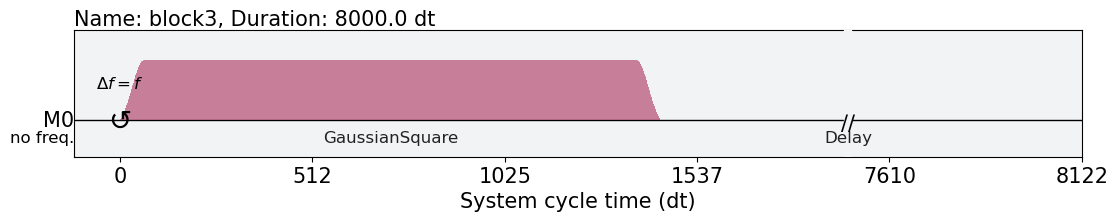

In [51]:
meas_spec_default.draw()

In [19]:
shift_meas_freqs = np.arange(-3*MHz, 1.03*MHz, 0.08*MHz)

In [20]:
len(shift_meas_freqs)

51

In [56]:
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])
xpi12 = r12(pi, 0)
Spect = Gate("Spectroscopy", 1, [shift_meas_freq])

In [57]:
qc_0 = QuantumCircuit(1, 1)
qc_0.append(Spect, [0])
qc_0.add_calibration(Spect, (0, ), meas_spec_default, [shift_meas_freq])
spec_0_circs = [qc_0.assign_parameters({shift_meas_freq: f}, inplace=False) for f in shift_meas_freqs]

In [58]:
qc_1 = QuantumCircuit(1, 1)
qc_1.x(0)
qc_1.append(Spect, [0])
qc_1.add_calibration(Spect, (0, ), meas_spec_default, [shift_meas_freq])
spec_1_circs = [qc_1.assign_parameters({shift_meas_freq: f}, inplace=False) for f in shift_meas_freqs]

In [59]:
qc_2 = QuantumCircuit(1, 1)
qc_2.x(0)
qc_2.append(Xpi12, [0])
qc_2.append(Spect, [0])
qc_2.add_calibration(Xpi12, (0, ), xpi12, [])
qc_2.add_calibration(Spect, (0, ), meas_spec_default, [shift_meas_freq])
spec_2_circs = [qc_2.assign_parameters({shift_meas_freq: f}, inplace=False) for f in shift_meas_freqs]

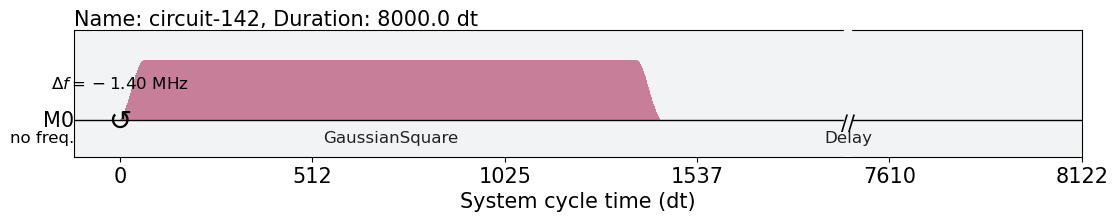

In [60]:
schedule(spec_0_circs[20], backend=backend).draw()

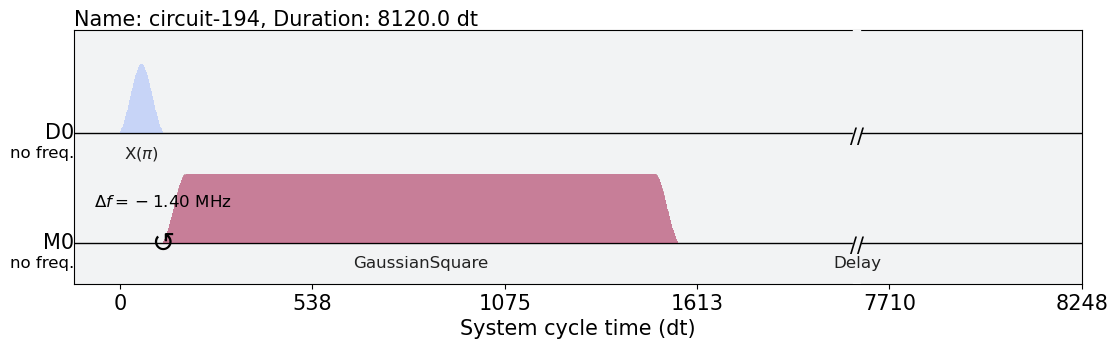

In [61]:
schedule(spec_1_circs[20], backend=backend).draw()

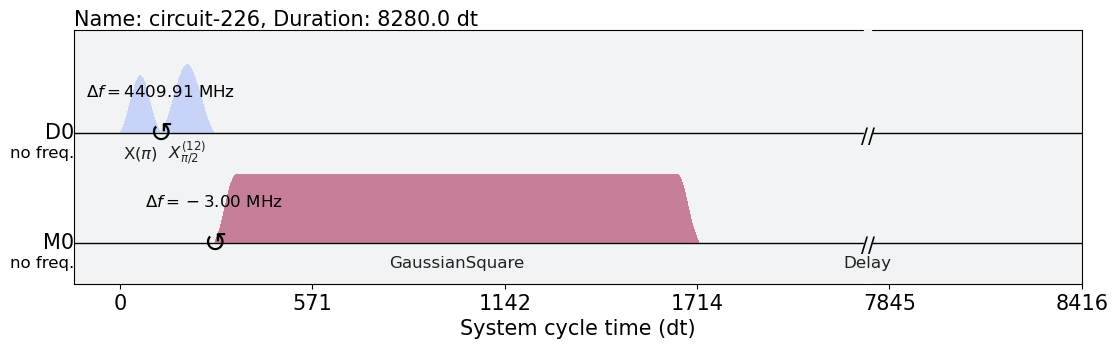

In [62]:
schedule(spec_2_circs[0], backend=backend).draw()

In [63]:
NUM_SHOTS

4096

In [64]:
list_ids = []
spec_circs = [spec_0_circs, spec_1_circs, spec_2_circs]
for circ in spec_circs:
    job = backend.run(circ, meas_level=1, meas_return='single', shots=NUM_SHOTS)
    list_ids.append(job.job_id())
    
list_ids

['cnna0pj8sy80008p2x4g', 'cnna0q20k0p00088v0cg', 'cnna0qt8sy80008p2x50']

In [41]:
job = provider.backend.retrieve_job('cnh13dxdpvjg008bgk4g')

In [42]:
job_monitor(job)

Job Status: job has successfully run


In [30]:
#list_ids = ['cnbtrja0m2gg008c8hfg', 'cnbtrjt0m2gg008c8hg0', 'cnbtrkjrbhc0008j7ha0']
#list_ids = ['cnc6frfrbhc0008j8tjg', 'cnc6fs7hga30008f14yg', 'cnc6fsqrbhc0008j8tk0']
#list_ids = ['cngaptba1dag008p6pb0', 'cngapvbjq8rg0080r6g0', 'cngapw3njjq0008adt50']
#list_ids = ['cnh13dxdpvjg008bgk4g', 'cnh13enxjp4g008mb3ag', 'cnh13fdxjp4g008mb3b0']
#list_ids = ['cnkp060q9ax00087eqrg', 'cnkp06r7aw9g008ghk00', 'cnkp0787aw9g008ghk0g']
#list_ids = ['cnm4zcdtpj7000842thg', 'cnm4zcxtpj7000842tj0', 'cnm4zdxbbx1g0087g270']
list_ids = ['cnna0pj8sy80008p2x4g', 'cnna0q20k0p00088v0cg', 'cnna0qt8sy80008p2x50']
datas_average = []
datas_single = []
for id in list_ids:
    job = provider.backend.retrieve_job(id)
    datas_average.append(get_job_data(job, average=True))
    datas_single.append(get_job_data(job, average=False))

In [31]:
zero_datas = datas_single[0]
one_datas = datas_single[1]
two_datas = datas_single[2]

In [32]:
zero_datas_reshaped = [reshape_complex_vec(zero_datas[i]) for i in range(51)]
one_datas_reshaped = [reshape_complex_vec(one_datas[i]) for i in range(51)]
two_datas_reshaped = [reshape_complex_vec(two_datas[i]) for i in range(51)]

In [33]:
discrimination_data = [[datas_single[0][i], datas_single[1][i], datas_single[2][i]] for i in range(len(datas_single[0]))]

In [34]:
len(discrimination_data)

51

In [35]:
def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    score = LDA_012.score(IQ_012_test, state_012_test)
    return LDA_012, score

In [36]:
NUM_SHOTS = 4096
confusion_matrices = []
scores = []
for data in discrimination_data:
    LDA_012, score = discriminate(data)
    count_data = count(data, LDA_012)
    conf_mat = np.array([[count_data[i]['0'] / NUM_SHOTS, count_data[i]['1'] / NUM_SHOTS, count_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(count_data)[0])])
    scores.append(score)
    confusion_matrices.append(conf_mat)

In [37]:
traces = [np.trace(confusion_matrices[i])/3 for i in range(len(confusion_matrices))]

In [38]:
for i in range(len(confusion_matrices)):
    if confusion_matrices[i][0][0] > 0.9 and confusion_matrices[i][1][1]> 0.9 and confusion_matrices[i][2][2] > 0.9:
        print(confusion_matrices[i], i)


[[0.93774414 0.0456543  0.01660156]
 [0.05029297 0.92724609 0.02246094]
 [0.01977539 0.03295898 0.94726562]] 5
[[0.94628906 0.04321289 0.01049805]
 [0.03637695 0.94848633 0.01513672]
 [0.01635742 0.02758789 0.95605469]] 6
[[0.96508789 0.02758789 0.00732422]
 [0.0324707  0.95825195 0.00927734]
 [0.00610352 0.02832031 0.96557617]] 7
[[0.97119141 0.0246582  0.00415039]
 [0.02661133 0.9621582  0.01123047]
 [0.00610352 0.03076172 0.96313477]] 8
[[0.97119141 0.02514648 0.00366211]
 [0.02685547 0.9597168  0.01342773]
 [0.00463867 0.03369141 0.96166992]] 9
[[0.97045898 0.02685547 0.00268555]
 [0.02514648 0.95849609 0.01635742]
 [0.00292969 0.0390625  0.95800781]] 10
[[0.97094727 0.02539062 0.00366211]
 [0.03125    0.94726562 0.02148438]
 [0.00390625 0.04077148 0.95532227]] 11
[[0.95800781 0.03710938 0.00488281]
 [0.04101562 0.92553711 0.03344727]
 [0.00830078 0.05175781 0.93994141]] 12
[[0.93798828 0.05419922 0.0078125 ]
 [0.05664062 0.90063477 0.04272461]
 [0.01098633 0.07006836 0.91894531]] 

In [96]:
shift_meas_freqs_MHz[20]

-1.4

In [40]:
datas_single

[[array([-6.2835293-6.0587675j, -0.1357054+2.554247j ,
          4.7993176+3.5154442j, ..., -6.1615677-3.4409948j,
          7.2413176+1.0295113j, -2.175684 +1.1407886j]),
  array([ 2.1625588-3.6465549j, -4.8877107-4.6239979j,
         -2.924281 +2.7144521j, ..., -0.5149773-0.3010167j,
         -6.4611292+3.4791666j,  6.3142613+1.1410008j]),
  array([ 3.5066745+10.0572549j, -8.6947381 +2.502195j ,
         -6.7345908 -7.2413117j, ...,  1.3141985 +4.4018589j,
         -7.6561819 +2.2143639j, -2.3505212 +1.3354566j]),
  array([-2.984922  +1.0487482j,  5.5244723+10.8281197j,
         -8.6970304 -4.3568801j, ...,  2.2912635 -3.2010199j,
         -0.6856455+12.8812059j,  3.6978483 -1.7846288j]),
  array([ 8.1605758+11.7110108j, -7.3333407 +0.1115749j,
          6.3122128+11.6040461j, ...,  5.9480511 +3.0090665j,
          5.0845309 -1.3310785j,  5.9933518 +4.9410791j]),
  array([ 4.312349 -1.4825581j, 14.4708729+0.4605153j,
          5.0878164+2.3706422j, ..., 13.0557687-2.942332j ,
       

In [88]:
datas_real = []
datas_imag = []
datas_modl = []
for data in datas_single:
    datas_real.append([np.real(np.average(data[i])) for i in range(len(shift_meas_freqs))])
    
for data in datas_single:
    datas_imag.append([np.imag(np.average(data[i])) for i in range(len(shift_meas_freqs))])
    
for data in datas_single:
    datas_modl.append([np.abs(np.average(data[i])) for i in range(len(shift_meas_freqs))])

Text(0.5, 0, 'Shift measure frequency')

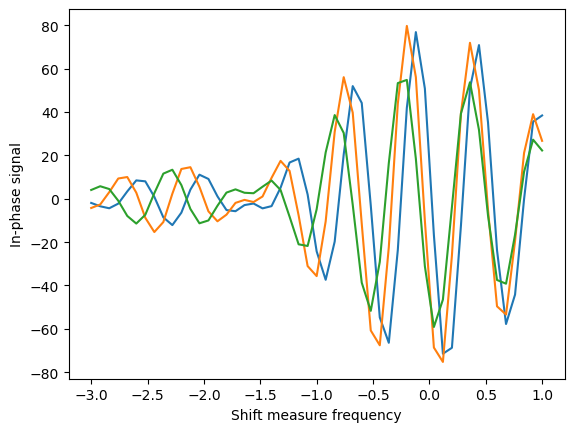

In [92]:
plt.plot(shift_meas_freqs_MHz, datas_real[0])
plt.plot(shift_meas_freqs_MHz, datas_real[1])
plt.plot(shift_meas_freqs_MHz, datas_real[2])
plt.ylabel("In-phase signal")
plt.xlabel("Shift measure frequency")

Text(0.5, 0, 'Shift measure frequency')

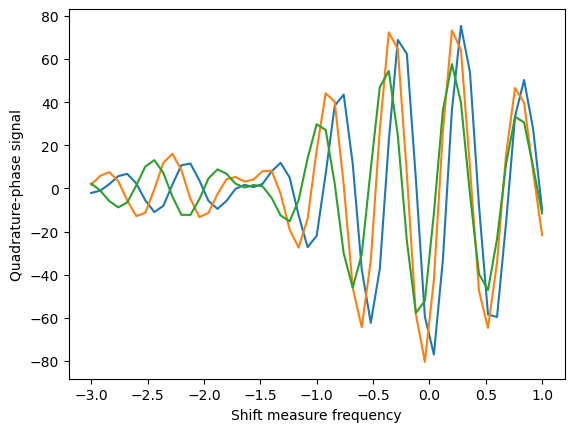

In [93]:
plt.plot(shift_meas_freqs_MHz, datas_imag[0])
plt.plot(shift_meas_freqs_MHz, datas_imag[1])
plt.plot(shift_meas_freqs_MHz, datas_imag[2])
plt.ylabel("Quadrature-phase signal")
plt.xlabel("Shift measure frequency")

Text(0.5, 0, 'Shift measure frequency')

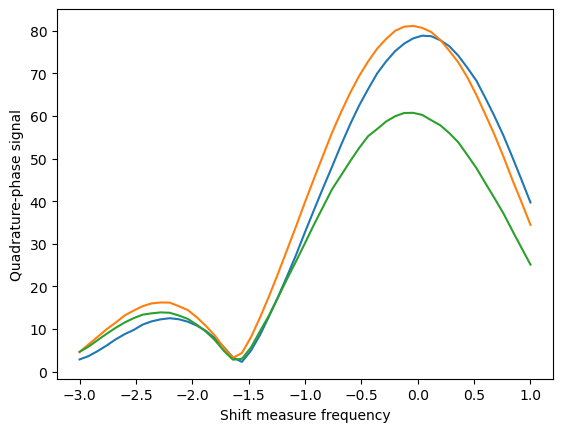

In [94]:
plt.plot(shift_meas_freqs_MHz, datas_modl[0])
plt.plot(shift_meas_freqs_MHz, datas_modl[1])
plt.plot(shift_meas_freqs_MHz, datas_modl[2])
plt.ylabel("Quadrature-phase signal")
plt.xlabel("Shift measure frequency")

Text(0, 0.5, 'Trace of confusion matrix')

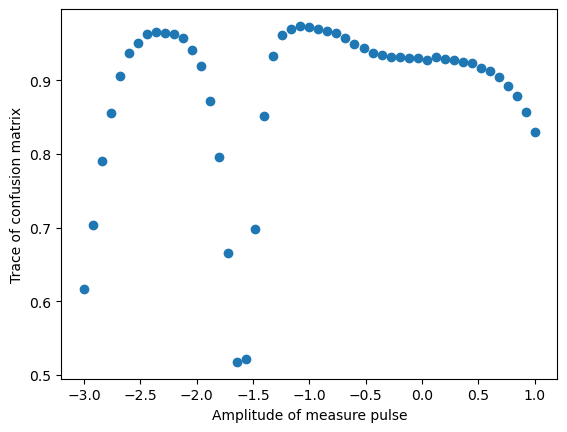

In [51]:
plt.scatter(shift_meas_freqs_MHz, [np.trace(confusion_matrices[i])/3 for i in range(len(confusion_matrices))])
plt.xlabel("Amplitude of measure pulse")
plt.ylabel("Trace of confusion matrix")
#plt.savefig("trace_conf_mat_meas_discriminator_11_29_2023")

Text(0, 0.5, 'Score of LDA on test set')

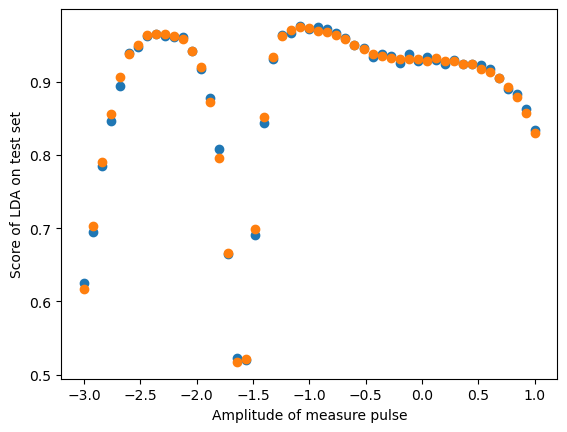

In [42]:
plt.scatter(shift_meas_freqs_MHz, scores)
plt.scatter(shift_meas_freqs_MHz, [np.trace(confusion_matrices[i])/3 for i in range(len(confusion_matrices))])
plt.xlabel("Amplitude of measure pulse")
plt.ylabel("Score of LDA on test set")
#plt.savefig("amp_meas_discriminator_11_29_2023")

In [43]:
zero_datas_reshaped = [reshape_complex_vec(datas_single[0][i]) for i in range(51)]
one_datas_reshaped = [reshape_complex_vec(datas_single[1][i]) for i in range(51)]
two_datas_reshaped = [reshape_complex_vec(datas_single[2][i]) for i in range(51)]

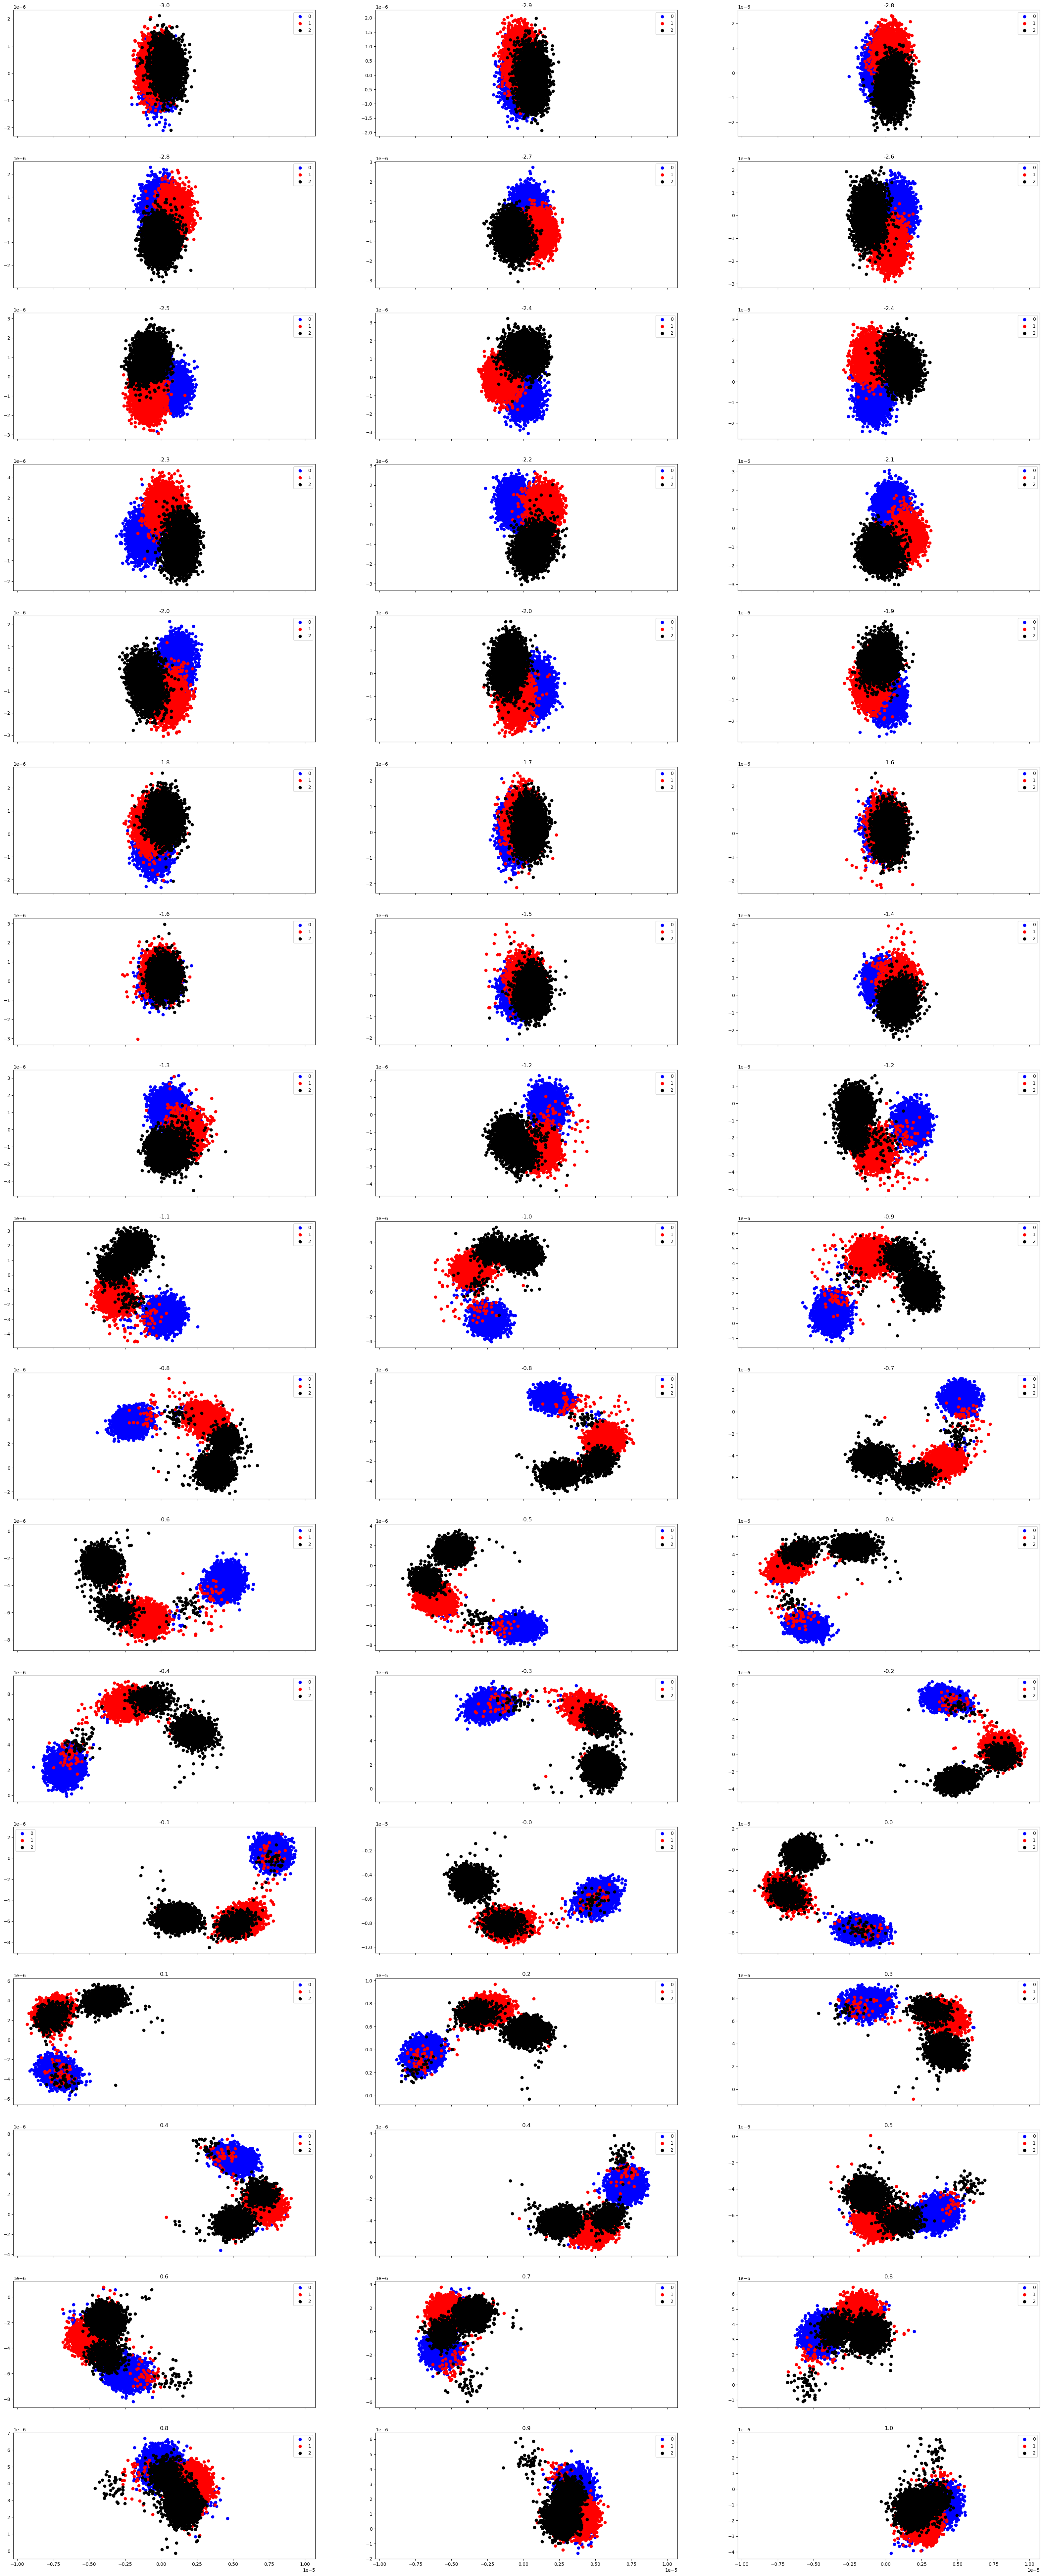

In [26]:
fig, axs = plt.subplots(nrows=17, ncols=3, sharex=True, figsize=(40, 100))
for i in range(17):
    for j in range(3):
        index = 3*i + j
        axs[i][j].scatter(zero_datas_reshaped[index][:, 0], zero_datas_reshaped[index][:, 1], color='blue', label='0')
        axs[i][j].scatter(one_datas_reshaped[index][:, 0], one_datas_reshaped[index][:, 1], color='red', label='1')
        axs[i][j].scatter(two_datas_reshaped[index][:, 0], two_datas_reshaped[index][:, 1], color='black', label='2')
        axs[i][j].legend()
        axs[i][j].set_title(np.round(shift_meas_freqs_MHz[index], 1))

In [30]:
shift_meas_freqs_MHz[20]

-1.0

In [22]:
shift_meas_freqs_MHz = shift_meas_freqs/MHz

In [15]:
fig.savefig("amp_1")